# **RSNA-MICCAI Brain Tumor Radiogenomic Classification**&#x1f600;
脳腫瘍治療に重要な遺伝子バイオマーカーの状態を予測する

※ English version is here.
https://www.kaggle.com/chumajin/brain-tumor-eda-for-starter-english-version

## このコンペは、MRIの画像から**脳腫瘍治療に重要な遺伝子バイオマーカーであるMGMTプロモーターのメチル化**を予測するコンペだと思います。


私みたいに専門外の人には、ちょっと何言っているかわからないと思います。

MGMTという遺伝子のプロモーター領域のメチル化の状態によって、化学療法に対する反応や予後が異なることが報告されているみたいです。

最近では、このメチル化の検査を参考にすることで、手術後の治療として、放射線治療か、化学療法かを適切に選択することができ、

これが患者さんの状態をよく保ちながら生存期間を延ばすことに役立つことがわかってきたみたいです。
※ https://www.h.u-tokyo.ac.jp/neurosurg/rinsho/noushu.htm を参考。


初め脳腫瘍かどうかを当てるコンペだと思ったのですが、そうではなく(English版でコメントもらいました)、

このデータセットに含まれるすべての被験者は脳腫瘍（膠芽腫）を持っているみたいです。

クラス0は、腫瘍がない人ではなく、MGMTプロモーターというもののメチル化がない人を指します。1はある人みたいです。それの確率を出すコンペです。


## 少しでもお役に立てば、upvoteして頂けると嬉しいです。
　※　以前も私のnotebookにupvoteしてくれた方ありがとうございます。
  ※ ver3以前は勘違いをしていました。ご指摘ありがとうございました(English version)
  
  ※ ver13～ dcmファイルの中身を見て、SliceLocationから、Scanごとの位置合わせを実行 (2.6～)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


# 1. 何を予測するか(submission.csvから見ます)

In [ ]:
sample = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")
sample

## BraTS21IDは患者のId、


* MGMT_valueはクラス0は、初め脳腫瘍がない人と思っていたのですが、MGMTプロモーターというもののメチル化がない人みたいです。

* 1はある人（腫瘍内の遺伝子配列があると、化学療法に対する反応性の好ましい予後因子および強力な予測因子。)これを予測します。

# 2. 何から予測するか ? train.csvを見ていく

## 2.1 train.csvとファイル構成

### test.csvはないので、train.csvを見てみます。

In [ ]:
train = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train

submissionとほぼ同じ情報。BraTS21IDは患者のId、MGMT_valueはMGMT promoterにメチル化があるかどうかの情報が載っています。


このtrainデータには、以下のように、


それぞれ、FLAIR,T1w,T1wCE,T2wがあって、その中にdcmファイルがぶら下がっています。

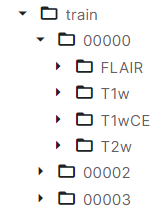

それぞれのIDに FLAIR, T1w, T1wCE, T2wというのが、紐づいています。

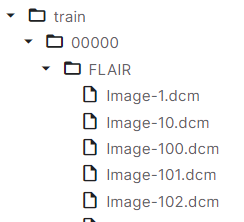

それぞれにたくさんのdcmファイルがある。

## 2.2 dcmファイルを1枚見てみる。

dcmファイルがどんなものか見るために、まず１枚dcmファイルを開く

In [ ]:
import pydicom
import matplotlib.pyplot as plt

dataset = pydicom.filereader.dcmread('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-109.dcm')
img = dataset.pixel_array

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.set_axis_off()
plt.show()

imgにするところだけ関数化します。（後程使います)

In [ ]:
def makeimg(path):
    dataset = pydicom.filereader.dcmread(path)
    img = dataset.pixel_array
    return img

## 2.3 FLAIR, T1w, T1wCE, T2wのイメージの代表例を見ていく。

pathを出した後この関数を使って、FLAIR, T1w, T1wCE, T2wのイメージの代表例を見てみます.


その前に、それぞれのフォルダーにdcmファイルが同じ数あるのか確認します。

### 2.3.1 dcmフォルダパスの作成

まず、dcm imageのパスを出していくことを考えます

In [ ]:
train["imfolder"] = ['{0:05d}'.format(s) for s in train["BraTS21ID"]]
train

In [ ]:
train_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

train["path"] = [os.path.join(train_path,s) for s in train["imfolder"]  ]
train

Scansとして、リスト化するとあとあとfor文で回しやすいです。

In [ ]:
Scans = ["FLAIR","T1w","T1wCE","T2w"]

## 2.3.2 dcmファイルの数の確認

そもそもこれらScansのdcmの数が、患者ごとに同じなのかを確認します。

In [ ]:
from tqdm import tqdm

1. まずはtrainの0行目のFLAIRのパスは以下のように表せます。

In [ ]:
train.head(3)

In [ ]:
os.path.join(train["path"].iloc[0],"FLAIR")

2. この中のファイル名はos.listdirを↑にくっければ取得できます。(表示が長いので、わざと3個にしています)

In [ ]:
os.listdir(os.path.join(train["path"].iloc[0],"FLAIR"))[:3]

3. ファイルの数はこれにlenをつければOKです。

In [ ]:
len(os.listdir(os.path.join(train["path"].iloc[0],"FLAIR")))

4. ↑のコードの"FLAIR"のところは、Scans[0]なので、置き換えて、for文で回します。また、0行目のところはリスト内包を使って振ると、以下の一文で全部DataFrameに収納できます。

In [ ]:
for scan in Scans:
    train[scan +"_count"] = [ len(os.listdir(os.path.join(train["path"].iloc[s],scan))) for s in tqdm(range(len(train))) ]



In [ ]:
train

同じ枚数のIDもあれば、違うのもあることが確認できます。

全部同じかの確認

In [ ]:
allsame = [train["FLAIR_count"].iloc[s] ==   train["T1w_count"].iloc[s] ==train["T1wCE_count"].iloc[s] ==train["T2w_count"].iloc[s] 
          for s in range(len(train))]

In [ ]:
train["allsame"] = allsame
train

Trueは1と扱われますので、足すと何個Trueがあるかわかります

In [ ]:
train["allsame"].sum()

In [ ]:
train["allsame"].sum()/len(train) * 100

585の患者idで、63患者Idが同じ枚数あることが確認された（約10%)。



## 2.4 画像数がそろっている人の画像を見て理解を深める

わかりやすくイメージするために、全部画像がそろっている人を

試しに、メチル化がある人 1　と　ない人 0の画像を並べて見てみましょう。


In [ ]:
train[train["allsame"]]

64行目のID100番の人(脳腫瘍である人)と、
65行目のID102番の人(そうでない人)の画像を全部見てみます。

まずは64行目の人をやって、関数化して65行目の人を見ます。

In [ ]:
row_ID = 64

In [ ]:
train["BraTS21ID"].iloc[row_ID]

In [ ]:
temp_folder = train["path"].iloc[row_ID]
temp_folder

pathをリスト化しちゃいます.まずはFLAIRで。

In [ ]:
temp_folder2 = os.path.join(temp_folder,"FLAIR")
temp_files = os.listdir(temp_folder2)
temp_files[:3]

あとで並び替えがきちんとできるようにここで、ファイル名の数字を取っておきます。

In [ ]:
imagenum = [s.split("-")[1] for s in temp_files]
imagenum = [s.split(".")[0] for s in imagenum]
imagenum[:3]

dcmのパスを出します

In [ ]:
temp_path = [os.path.join(temp_folder2,s) for s in temp_files]
temp_path[:3]

dataframeにして並び替えます。

In [ ]:
tempdf = pd.DataFrame()
tempdf["image_num"] = imagenum
tempdf["image_num"] = tempdf["image_num"].astype("int")

tempdf["temp_path"] = temp_path

image_numを使ってきれいに、並び替えます。↑でint型にして数字にすることが重要。下の絵のように、よくある1.dcm　→　10.dcmみたいに並ぶと時系列が崩れるため

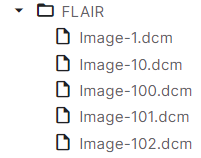

In [ ]:
tempdf.head(3)

In [ ]:
tempdf = tempdf.sort_values("image_num").reset_index(drop=True)
tempdf.head(3)

finpathに収納。

In [ ]:
finpath = tempdf["temp_path"]

これらを関数化(関数は長く見えますが、↑の64行目の人のコードをここまでコピーして、FLAIRをscanという表現にしただけ)します。
Scansのリストをfor文で回して、これでFLAIR以外も一気に出します

In [ ]:
def makepath(row_ID,scan):
    
    temp_folder = train["path"].iloc[row_ID]
    temp_folder2 = os.path.join(temp_folder,scan)
    temp_files = os.listdir(temp_folder2)
    imagenum = [s.split("-")[1] for s in temp_files]
    imagenum = [s.split(".")[0] for s in imagenum]
    temp_path = [os.path.join(temp_folder2,s) for s in temp_files]
    tempdf = pd.DataFrame()
    tempdf["image_num"] = imagenum
    tempdf["image_num"] = tempdf["image_num"].astype("int")
    tempdf["temp_path"] = temp_path
    tempdf = tempdf.sort_values("image_num").reset_index(drop=True)
    finpath = tempdf["temp_path"]
    return finpath

In [ ]:
Scans

row Id の一覧を作成(同じ数とわかっているからdataframe化できる。他はできない)

In [ ]:
row_id=64

sampledf = pd.DataFrame()
for scan in Scans:
    sampledf[scan + "_path"] = makepath(row_id,scan)

In [ ]:
sampledf.head(3)

## **MGMT_value=1の人**

(遺伝子にメチル化がある人 = 化学療法に対する反応性の好ましい予後因子および強力な予測因子がある人)の画像表示

In [ ]:
print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))


for row in range(len(sampledf)):
    plt.figure(figsize=(80,10))
    for num,scan in enumerate(Scans):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,25,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)

        

FLAIRなどは同じ位置を取っているが、見え方が違うことがわかる。

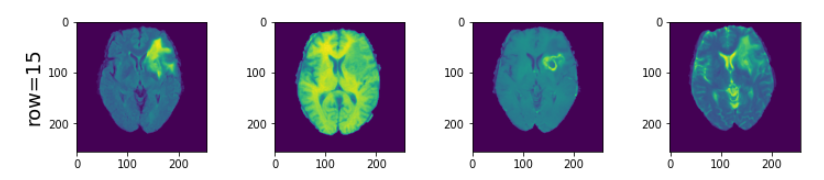

これの右上あたりが、特徴的なので、メチル化しているのかなと推測します。

## **MGMT_value=0の人

(遺伝子にメチル化がない人 = 化学療法に対する反応性の好ましい予後因子および強力な予測因子がない人)**の画像表示

In [ ]:
row_id = 65

sampledf = pd.DataFrame()
for scan in Scans:
    sampledf[scan + "_path"] = makepath(row_id,scan)

print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))

for row in range(len(sampledf)):
    plt.figure(figsize=(80,10))
    for num,scan in enumerate(Scans):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,25,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)

        

この辺↓は怪しいけど、この人は0なので、メチル化は見つからない。全体的にも怪しいところは少ない。これらの情報からテストデータも見ていくのだと推測。

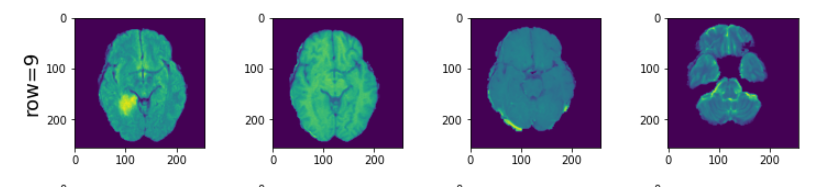

ぱっと見の感覚ですが、最初の方と最後の方は真っ暗だったりするから、何枚かピックアップするなら真ん中くらいの方がいいかもしれませんね。

## 2.5 各スキャンのファイル数がそろっていない時 (これが約90%)

データの数が４種類でそろっていないとき、時系列的に数字は同じなのか ? それとも単なる連番なのか ?
id = 0番の人を見てみます

In [ ]:
train

ID 0番の人33枚見てみる (T1wの個数が33枚で一番少ないため)

In [ ]:
row_id = 0

sampledf = pd.DataFrame()
for scan in Scans:
    sampledf[scan + "_path"] = makepath(row_id,scan)

In [ ]:
sampledf

In [ ]:
sampledf["T1w_path"].iloc[32]

下の方がNanになっていること確認. 番号が若い順に並び変えていて、32行目が33なので、ファイル名は連番

In [ ]:
print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))

for row in range(33):
    plt.figure(figsize=(80,5))
    for num,scan in enumerate(Scans):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,33,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)

        

T1Wだけ33枚しかないが、明らかにタイミングがずれているので、ファイル名と時間差がありそう。
dcmファイルから何か他に情報出せるのかも(v13~ 2.6に追記しました)。

## 2.6 dcmファイルのlocation情報から画像をそろえてみる(v13～)

https://www.kaggle.com/andradaolteanu/siim-covid-19-box-detect-dcm-metadata

を参照にdcmファイルの中身を見てみる

In [ ]:
def get_observation_data(path):
    """Get information from the .dcm files.
    path: complete path to the .dcm file"""

    image_data = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "FileNumber" : path.split("/")[5],
        "Rows" : image_data.get("Rows"),
        "Columns" : image_data.get("Columns"),
        "PatientID" : image_data.get("PatientID"),
        "BodyPartExamined" : image_data.get("BodyPartExamined"),
        "RotationDirection" : image_data.get("RotationDirection"),
        "ConvolutionKernel" : image_data.get("ConvolutionKernel"),
        "PatientPosition" : image_data.get("PatientPosition"),
        "PhotometricInterpretation" : image_data.get("PhotometricInterpretation"),
        "Modality" : image_data.get("Modality"),
        "StudyInstanceUID" : image_data.get("StudyInstanceUID"),
        "PixelPaddingValue" : image_data.get("PixelPaddingValue"),
        "SamplesPerPixel" : image_data.get("SamplesPerPixel"),
        "BitsAllocated" : image_data.get("BitsAllocated"),
        "BitsStored" : image_data.get("BitsStored"),
        "HighBit" : image_data.get("HighBit"),
        "PixelRepresentation" : image_data.get("PixelRepresentation"),
        "RescaleType" : image_data.get("RescaleType"),
    }

    # Integer columns
    int_columns = ["SliceThickness", "KVP", "DistanceSourceToDetector", 
        "DistanceSourceToPatient", "GantryDetectorTilt", "TableHeight", 
        "XRayTubeCurrent", "GeneratorPower", "WindowCenter", "WindowWidth", 
        "SliceLocation", "RescaleIntercept", "RescaleSlope"]
    for k in int_columns:
        observation_data[k] = int(image_data.get(k)) if k in image_data else None

    # String columns
    str_columns = ["ImagePositionPatient", "ImageOrientationPatient", "ImageType", "PixelSpacing"]
    for k in str_columns:
        observation_data[k] = str(image_data.get(k)) if k in image_data else None

    
    return observation_data

example

In [ ]:
get_observation_data('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/FLAIR/Image-20.dcm')

この中のSliceLocationをtrainの0行目の患者で、各スキャンでそろえてみます。

1. 最も画像がたくさんあるscanのSliceLocationを算出

In [ ]:
Scans

In [ ]:
Scancount = [s + "_count" for s in Scans]
Scancount

In [ ]:
master = train[Scancount].iloc[0].idxmax()
masterpath = makepath(0,master.split("_")[0])
masterloc = [get_observation_data(masterpath[b])["SliceLocation"] for b in range(len(masterpath))]
masterloc[:10]

2. 各pathとlocationの関係を取得

In [ ]:
sdict = []
for a in Scans:
    path = makepath(0,a)
    scanloc = [get_observation_data(path[b])["SliceLocation"] for b in range(len(path))]
    scandict = dict(zip(scanloc,path))
    sdict.append(scandict)

example : Scans[0]　のlocation -88

In [ ]:
sdict[0][-88]

3. 画像が一番多かったscanのlocationをmasterlocとしてdataFrame作成

In [ ]:
masterdf = pd.DataFrame(masterloc,columns=["masterloc"])
masterdf.head(5)

4. 重複削除 ( 同じlocationの画像があるみたい )

In [ ]:
masterdf = masterdf.drop_duplicates().reset_index(drop=True)
masterdf

5. 各scanごとに対応箇所のパスを展開

In [ ]:
for num,scan in enumerate(Scans):
    masterdf[scan] = masterdf["masterloc"].map(sdict[num])

In [ ]:
masterdf

6. nanデータの行削除

In [ ]:
masterdf=masterdf.dropna(how="any")
masterdf = masterdf.reset_index(drop=True)

In [ ]:
masterdf

7. 患者情報、MGMT_valueを追記

In [ ]:
masterdf["BraTS21ID"]=train["BraTS21ID"].iloc[0]
masterdf["MGMT_value"]=train["MGMT_value"].iloc[0]


In [ ]:
masterdf

1-7を関数化(コピーして、0をイメージ番号に変えただけ)

In [ ]:
def making_loc_path(row):
    

    master = train[Scancount].iloc[row].idxmax()
    masterpath = makepath(row,master.split("_")[0])
    masterloc = [get_observation_data(masterpath[b])["SliceLocation"] for b in range(len(masterpath))]

    sdict = []
    for a in Scans:
        path = makepath(row,a)
        scanloc = [get_observation_data(path[b])["SliceLocation"] for b in range(len(path))]
        scandict = dict(zip(scanloc,path))
        sdict.append(scandict)

    masterdf = pd.DataFrame(masterloc,columns=["masterloc"])

    for num,scan in enumerate(Scans):
        masterdf[scan] = masterdf["masterloc"].map(sdict[num])


    masterdf =masterdf.dropna(how="any")

    masterdf = masterdf.drop_duplicates()
    masterdf = masterdf.reset_index(drop=True)
    
        
    masterdf["BraTS21ID"]=int(train["BraTS21ID"].iloc[row])
    masterdf["MGMT_value"]=int(train["MGMT_value"].iloc[row])

    
    return masterdf


試しに先ほどの0行目の画像を見てみる

In [ ]:
train[train.index==0]

In [ ]:
vi = making_loc_path(0)
vi

## 2.7 Visualization

In [ ]:

for row in range(len(vi)):
    plt.figure(figsize=(80,5))
    for num,scan in enumerate(Scans):
        img = makeimg(vi[scan].iloc[row])
        plt.subplot(4,len(vi),num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("loc=" + str(vi["masterloc"].iloc[row]),fontsize=18)

        

T2wのスキャン向きが違う気もするが、場所としては合っていそうな気がする。

別の例で、T2wのスキャン方向がそろっていたもの。560行目

In [ ]:
train[train.index==560]

In [ ]:
vi = making_loc_path(560)
vi

In [ ]:
for row in range(len(vi)):
    plt.figure(figsize=(80,5))
    for num,scan in enumerate(Scans):
        img = makeimg(vi[scan].iloc[row])
        plt.subplot(4,len(vi),num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("loc=" + str(vi["masterloc"].iloc[row]),fontsize=18)

        

合っていそうなことを確認。T2wのスキャン方向はこれは他とそろっているので、種類があるのは気になります。

# 3. テストデータ

## 3.1 Scanごとの画像数がどれくらい同じなのか確認。

コードは基本trainと同じなので、まとめてしまいます。

In [ ]:
sample["imfolder"] = ['{0:05d}'.format(s) for s in sample["BraTS21ID"]]

test_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/test"

sample["path"] = [os.path.join(test_path,s) for s in sample["imfolder"]  ]


allres = []

for scan in Scans:
    sample[scan +"_count"] = [ len(os.listdir(os.path.join(sample["path"].iloc[s],scan))) for s in tqdm(range(len(sample))) ]

In [ ]:
sample

In [ ]:
allsame = [sample["FLAIR_count"].iloc[s] ==   sample["T1w_count"].iloc[s] ==sample["T1wCE_count"].iloc[s] ==sample["T2w_count"].iloc[s] 
          for s in range(len(sample))]

sample["allsame"] = allsame

sample

In [ ]:
sample["allsame"].sum()

In [ ]:
sample["allsame"].sum()/len(sample) * 100

testデータも約12%は数がそろっている。

# 4. Submit

テスト的に何か変えて出したい。例えば、画像枚数が同じ場合の傾向を見てみる。

In [ ]:
train.groupby("allsame")["MGMT_value"].mean().reset_index()

若干の差異がありそうなので、これで出してみます。

In [ ]:
sample["MGMT_value"] = np.where(sample["allsame"],0.460317,0.532567)

In [ ]:
sample

In [ ]:
sample= sample[["BraTS21ID","MGMT_value"]]

In [ ]:
sample.to_csv("submission.csv",index=False)

In [ ]:
sample

# 最後まで見ていただいてありがとうございます。

※以前も私のnotebookにupvoteしてくれた方ありがとうございます。

# お役に立てば、**upvote**いただけたら嬉しいです！

* 最初の方はこのコンペティションは脳腫瘍ある・なしと間違って解釈していました。English版で訂正いただきました。ありがとうございます。そして、初めの方申し訳ございません。